('Check of exact solution:', None)
[1 - x, (1 - x)**2]
...evaluating matrix... (0,0): 1
(0,1): 2 - 2*x
rhs: D - 2*x + 2
(1,1): (2*x - 2)**2
rhs: -D*(2*x - 2) + 2*(1 - x)**2

A:
 Matrix([[1, 1], [1, 4/3]]) 
b:
 Matrix([[-C + D + 1], [-C + D + 2/3]])
coeff: [-C + D + 2, -1]
approximation: -(1 - x)**2 + (1 - x)*(-C + D + 2)
('numerical solution:', D*x - (1 - x)**2 + (1 - x)*(-C + D + 2))
('simplified:', C*x - C + D - x**2 + 1)
('u exact', C*x - C + D - x**2 + 1)
('u:', {'G1': -(1 - x)**2 - 2, 'exact': -x**2 + 2*x - 3})


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


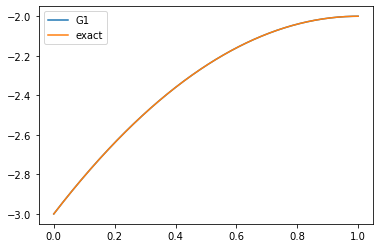

In [1]:
from varform1D import *
import sympy as sym
import numpy as np

def phi_factory(name, N, highest_derivative=2):
    """
    Generate N+1 basis functions (phi) on [0,1] which vanish
    on the boundary. Differentiate the functions up to
    (and including) highest_derivative.
    """
    x = sym.Symbol('x')
    from sympy import sin, cos, pi
    if name == 'sines':
        phi = {0: [sin(pi*(i+1)*x) for i in range(N+1)]}
    elif name == 'poly':
        phi = {0: [x**(i+1)*(1-x) for i in range(N+1)]}
    elif name == 'poly2':
        phi = {0: [x**(i+2)*(1-x) for i in range(N+1)]}
    elif name == 'poly3':
        phi = {0: [(1-x)**(i+1) for i in range(N+1)]}
    elif name == 'Lagrange':
        from Lagrange import Lagrange_polynomials
        # Return all Lagrange polynomials and strip off
        # boundary polynomials in application code (if necessary)
        phi = {0: Lagrange_polynomials(x, N, [0,1], 'uniform')[0]}
    elif name == 'Lagrange_Cheb':
        from Lagrange import Lagrange_polynomials
        phi = {0: Lagrange_polynomials(x, N, [0,1], 'Chebyshev')}

    # Compute derivatives of the basis functions
    for d in range(1, highest_derivative+1):
        phi[d] = [sym.diff(phi[0][i], x, d) for i in range(len(phi[0]))]
    return phi


def case0(f, N=3):
    B = 1 - x**3
    dBdx = sym.diff(B, x)

    # Compute basis functions and their derivatives
    phi = {0: [x**(i+1)*(1-x) for i in range(N+1)]}
    phi[1] = [sym.diff(phi_i, x) for phi_i in phi[0]]

    def integrand_lhs(phi, i, j):
        return phi[1][i]*phi[1][j]

    def integrand_rhs(phi, i):
        return f*phi[0][i] - dBdx*phi[1][i]

    Omega = [0, 1]

    u_bar, _ = solver(integrand_lhs, integrand_rhs, phi, Omega,
                      verbose=True, symbolic=True)
    u = B + u_bar
    print(('solution u:', sym.simplify(sym.expand(u))))

    # Calculate analytical solution

    # Solve -u''=f by integrating f twice
    f1 = sym.integrate(f, x)
    f2 = sym.integrate(f1, x)
    # Add integration constants
    C1, C2 = sym.symbols('C1 C2')
    u_e = -f2 + C1*x + C2
    # Find C1 and C2 from the boundary conditions u(0)=0, u(1)=1
    s = sym.solvers.solve([u_e.subs(x,0) - 1, u_e.subs(x,1) - 0], [C1, C2])
    # Form the exact solution
    u_e = -f2 + s[C1]*x + s[C2]
    print(('analytical solution:', u_e))
    #print 'error:', u - u_e  # many terms - which cancel
    print(('error:', sym.expand(u - u_e)))


def case1(N, basis='sines'):
    """
    Solve -u''=f(x) on [0,1], u(0)=u(1)=0. f(x)=2.
    Method: least-squares, Galerkin, collocation.
    """

    f = 2
    D = 0; L = 1

    def integrand_lhs_LS(phi, i, j):
        return -phi[2][i]*phi[2][j]

    def integrand_rhs_LS(phi, i):
        return f*phi[2][i]

    def integrand_lhs_G2(phi, i, j):
        return -phi[0][i]*phi[2][j]

    def integrand_rhs_G2(phi, i):
        return f*phi[0][i]

    def integrand_lhs_G1(phi, i, j):
        return phi[1][i]*phi[1][j]

    def integrand_rhs_G1(phi, i):
        return f*phi[0][i]

    def term_lhs_co(phi, x, i, j):
        return -phi[2][j](x[i])

    def term_rhs_co(phi, x, i):
        return 2

    Omega = [0, 1]
    phi = phi_factory(basis, N, 2)
    u = {}  # dict of solutions corresponding to different methods
    u['LS'] = solver(integrand_lhs_LS, integrand_rhs_LS, phi, Omega)[0]
    u['G1'] = solver(integrand_lhs_G1, integrand_rhs_G1, phi, Omega)[0]
    u['G2'] = solver(integrand_lhs_G2, integrand_rhs_G2, phi, Omega)[0]
    u['exact'] = x*(D + L - x)
    # Test different collocation points
    points = []
    if N == 0:
        points.extend([sym.Rational(1,2), 0.1, 0.9])
    else:
        points.append(np.linspace(0.1, 0.9, N+1))  # uniformly distributed
        for seed in 2, 10:
            np.random.seed(seed)
            points.append(np.random.uniform(0, 1, size=N+1))
    for k, p in enumerate(points):
        u['co'+str(k)] = collocation(term_lhs_co, term_rhs_co, phi, p)
    import pprint; pprint.pprint(u)
    comparison_plot(u, [0, 1])

def case2(N):
    """
    Solve -u''=f(x) on [0,1], u'(0)=C, u(1)=D.
    Method: Galerkin only.
    """
    x = sym.Symbol('x')
    f = 2
    D = 2; E = 3;
    L = 1  # basis function factory restricted to [0,1]
    D = sym.Symbol('D')
    C = sym.Symbol('C')

    # u exact
    f1 = sym.integrate(f, x)
    f2 = sym.integrate(f1, x)
    C1, C2 = sym.symbols('C1 C2')
    u = -f2 + C1*x + C2
    BC1 = sym.diff(u,x).subs(x, 0) - C
    BC2 = u.subs(x,1) - D
    s = sym.solve([BC1, BC2], [C1, C2])
    u_e = -f2 + s[C1]*x + s[C2]

    def diff_eq(u, x):
        eqs =  {'diff': -sym.diff(u, x, x) - f,
                'BC1': sym.diff(u, x).subs(x, 0) - C,
                'BC2': u.subs(x, L) - D}
        for eq in eqs:
            eqs[eq] = sym.simplify(eqs[eq])

    print(('Check of exact solution:', diff_eq(u_e, x)))

    def integrand_lhs(phi, i, j):
        return phi[1][i]*phi[1][j]

    B = D*x/L
    dBdx = sym.diff(B, x)

    def integrand_rhs(phi, i):
        return f*phi[0][i] - dBdx*phi[1][i]

    boundary_lhs = None # not used here

    def boundary_rhs(phi, i):
        return -C*phi[0][i].subs(x, 0)

    Omega = [0, L]
    phi = phi_factory('poly3', N, 1)
    #phi = phi_factory('Lagrange', N, 1)
    print((phi[0]))
    u = {'G1': solver(integrand_lhs, integrand_rhs, phi, Omega,
                      boundary_lhs, boundary_rhs, verbose=True)[0] + B,
         'exact': u_e}
    print(('numerical solution:', u['G1']))
    print(('simplified:', sym.simplify(u['G1'])))
    print(('u exact', u['exact']))
    # Change from symblic to numerical computing for plotting.
    # That is, replace C and D symbols by numbers
    # (comparison_plot takes the expressions with x to functions of x
    # so C and D must have numbers).
    for name in u:
        u[name] = u[name].subs(C, 2).subs(D, -2)
    print(('u:', u))
    C = 2;  D = -2  # Note that these are also remembered by u_e
    comparison_plot(u, [0, 1])

def case3(N, a=1, a_symbols={}, f=0, f_symbols={},
          basis='poly', symbolic=True, B_type='linear'):
    """
    Solve -(a(x)u)'=0 on [0,1], u(0)=1, u(1)=0.
    Method: Galerkin.
    a and f must be sympy expressions with x as the only symbol
    (other symbols in a gives very long symbolic expressions in
    the solution and is of little value).
    """
    # Note: a(x) with symbols
    #f = sym.Rational(10,7)  # for a=1, corresponds to f=0 when a=1/(2+10x)

    """
    def a(x):  # very slow
        return sym.Piecewise((a1, x < sym.Rational(1,2)),
                            (a2, x >= sym.Rational(1,2)))

    def a(x):  # cannot be treated by sympy or wolframalpha.com
        return 1./(a1 + a2*x)

    # Symbolic a(x) makes large expressions...
    def a(x):
        return 2 + b*x
    def a(x):
        return 1/(2 + b*x)

    def a(x):
        return 1/(2 + 10*x)

    b = sym.Symbol('b')
    def a(x):
        return sym.exp(b*x)
    """
    if f == 0:
        h = sym.integrate(1/a, x)
        h1 = h.subs(x, 1)
        h0 = h.subs(x, 0)
        u_exact = 1 - (h-h0)/(h1-h0)
    else:
        # Assume a=1
        f1 = sym.integrate(f, x)
        f2 = sym.integrate(f1, x)
        C1, C2 = sym.symbols('C1 C2')
        u = -f2 + C1*x + C2
        BC1 = u.subs(x,0) - 1
        BC2 = u.subs(x,1) - 0
        s = sym.solve([BC1, BC2], [C1, C2])
        u_exact = -f2 + s[C1]*x + s[C2]
    print(('u_exact:', u_exact))

    def integrand_lhs(phi, i, j):
        return a*phi[1][i]*phi[1][j]

    def integrand_rhs(phi, i):
        return f*phi[0][i] - a*dBdx*phi[1][i]

    boundary_lhs = boundary_rhs = None # not used here

    Omega = [0, 1]
    if B_type == 'linear':
        B = 1 - x
    elif B_type == 'cubic':
        B = 1 - x**3
    elif B_type == 'sqrt':
        B = 1 - sym.sqrt(x)
    else:
        B = 1 - x
    if basis == 'poly':
        phi = phi_factory('poly', N, 1)
    elif basis == 'Lagrange':
        phi = phi_factory('Lagrange', N, 1)
        print(('len phi:', len(phi)))
        B = phi[0][0]*1 + phi[0][-1]*0
        phi[0] = phi[0][1:-1]
        phi[1] = phi[1][1:-1]
    elif basis == 'sines':
        phi = phi_factory('sines', N, 1)
    else:
        raise ValueError('basis=%s must be poly, Lagrange or sines' % basis)
    print(('Basis functions:', phi[0]))

    dBdx = sym.diff(B, x)

    verbose = True if symbolic else False
    phi_sum, _ = solver(integrand_lhs, integrand_rhs, phi, Omega,
                        boundary_lhs, boundary_rhs, verbose=verbose,
                        symbolic=symbolic)
    print(('sum c_j*phi_j:', phi_sum))
    name = 'numerical, N=%d' % N
    u = {name: phi_sum + B, 'exact': sym.simplify(u_exact)}
    print(('Numerical solution:', u[name]))
    if verbose:
        print(('...simplified to', sym.simplify(u[name])))
        print(('...exact solution:', sym.simplify(u['exact'])))

    f_str = str(f).replace(' ', '')
    a_str = str(a).replace(' ', '')
    filename = 'DaDu=-%s_a=%s_N%s_%s.eps' % (f_str, a_str, N, basis)
    # Change from symblic to numerical computing for plotting.
    all_symbols = {}
    all_symbols.update(a_symbols)
    all_symbols.update(f_symbols)
    if all_symbols:
        for s in all_symbols:
            value = all_symbols[s]
            print(('symbol', s, 'gets value', value))
            u[name] = u[name].subs(s, value)
            u['exact'] = u['exact'].subs(s, value)
    print(('Numerical u_exact formula before plot:', u_exact))
    comparison_plot(u, [0, 1], filename)


def comparison_plot(u, Omega, filename='tmp.eps'):
    """
    Plot the solution u(x) (a sympy expression with x as the only
    symbol - all other symbols must have been substituted by numbers)
    and the exact solution u_e (which is a Python function that can
    take an array x and return the values of the exact solution).
    Omega is a 2-tuple/list with the domain's lower and upper limit.
    """
    x = sym.Symbol('x')
    resolution = 401
    xcoor = np.linspace(Omega[0], Omega[1], resolution)
    for name in u:
        u[name] = sym.lambdify([x], u[name], modules="numpy")
        u[name] = u[name](xcoor)
    legends = []
    for name in u:
        plt.plot(xcoor, u[name])
        legends.append(name)
    plt.legend(legends)
    plt.savefig(filename)

x, b = sym.symbols('x b')

#case1(8, 'sines')
#case2(1)
#case3(4)
#case3(N=3, a=sym.exp(b*x), f=0, basis='poly',
#      a_symbols={b: 8}, f_symbols={})
#case3(N=2, a=1, f=b, basis='poly', f_symbols={b: 10}, B_type='cubic')

#case0(f=b, N=1)
#case0(f=x**6, N=7)
case2(1)


